 2) Design a combinatorial bandit algorithm to optimize the budget allocation over the three subcampaigns
  to maximize the total number of clicks. Plot the cumulative regret.
prima si stimano le curve (budget allocato -> numero di click + rumore gaussiano)\n",
poi crea la tabella e si trova la combinazione migliore di sub per avere il massimo numero di click\n",


    CURVE\n",
    MAX_BUDGET * (1.0 - np.exp(-(PARAMETRO_SUB * x))\n",

    RUMORE: generazione sample con rumore\n",
    SAMPLE = np.random.normal(CLICK_Y_CURVA, VARIANZA_FISSA)\n",
    CLICK_Y_CURVA = valore del numero di click preso dalla curva dato un budget x\n",

   Dai vari SAMPLE si generano le  3 CURVA_GEN con un GP\n",

    Dalle curve si riempie la prima tabella con i valori di budget prefissati:
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    Si applica l'optimization problem per decidere la combinazione migliore di subcampaign

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner
import pandas as pd
from project.Urbano08.Optimizer import Optimizer


In [2]:
n_obs = 50
n_subcamp = 3
max_bid = 1
max_clicks = 100
n_arms = 11

bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])

noise_std = 6.0
env = BiddingEnvironment(bids,max_clicks,noise_std)

learners = []
for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
# BISOGNA USARE IL DATAFRAME DI PANDA AL POSTO DEGLI X_OBS E Y_OBS  (PER ORA SONO DATI RIPETUTI)
for i in range(0, n_obs):
    clicks = []

    #Pull an arm for each sub-campaign:
    #It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
    #For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
    ### N.B. This behaviour works only for arms linearly distributed  over the array_bids
    first = i % 3
    pulled = [0,0,0]
    pulled[first] = learners[first].pull_arm()
    pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
    pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

11
11
11


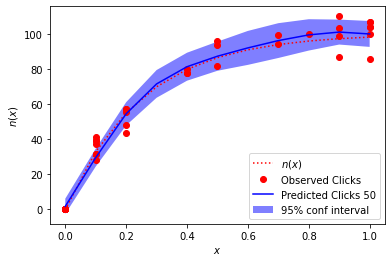

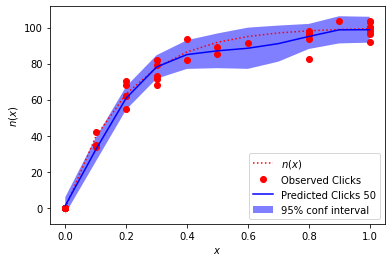

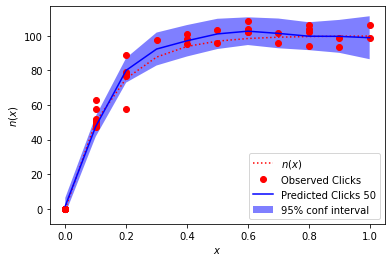

In [4]:

for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])

## Optimization algorithm
Now we solve the optimization problem as a special case of Multiple-Choice Knapsack problem (Sinha and Zoltners 1979),
Here we use the samples returned by the bandit algorithms.

In [5]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)


[[  1.80054903  29.55059507  54.4783322   71.5034539   81.2993044
   87.28200768  92.0157561   96.17789157  99.41894243 101.02157299
   99.94697162]
 [  1.24428152  32.19620412  60.83249611  78.12129596  85.00154982
   87.07124003  88.49561472  91.05919164  95.03616275  98.71554827
   98.78167039]
 [  1.63721451  47.58036758  80.08128601  92.40630074  97.18958898
  101.16099047 102.74238934 101.45522506  99.83735978  99.74070965
   98.94662755]]


In [6]:
algorithm_table = np.ndarray(shape=(0,len(bids)), dtype=float)

for l in learners:
   algorithm_table = np.append(algorithm_table,np.atleast_2d(np.zeros(len(bids))),0)

algorithm_table[0,:] = table_all_Subs[0,:]

allocations_table = [[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]]


for i in range(1, n_subcamp):
    allocations_table.append([[],[],[],[],[],[],[],[],[],[],[]])

    for j in range(0, len(bids)):
        possibilities = np.array([])
        poss_allocation = []
        for p in range(0,j+1):
            #if bids[p] + bids[j-p] <= bids[j] :
            possibilities = np.append(possibilities, table_all_Subs[i,p]+algorithm_table[i-1,j-p])
            poss_allocation.append(allocations_table[i-1][j-p] + [p])
            #print(str(i)+" "+ str(p) + " "+ str(j-p))

        max_index = np.argmax(possibilities)
        #print(poss_allocation)
        #print(possibilities)

        #print(max_index)
        algorithm_table[i,j] = possibilities[max_index]
        allocations_table[i][j] = poss_allocation[max_index]


Applicare l'algoritmo della tabella alla curva ideale per trovare l'optimal
sottrarre i reward (somma dei click) di ogni turno dall'optimal trovato 
Plottare il regret sommando le differenze

In [7]:
print(allocations_table[n_subcamp-1])
print(max(algorithm_table[n_subcamp-1]))
print(total_click_each_day)


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [0, 2, 2], [1, 2, 2], [2, 2, 2], [2, 3, 2], [3, 3, 2], [3, 3, 3], [4, 3, 3]]
251.82690109694587
    bid_sub1  bid_sub2  bid_sub3      click1      click2      click3
0        0.0       2.0       8.0    0.000000   68.312389   94.248668
1        2.0       8.0       0.0   57.223374   96.865947    0.000000
2        4.0       3.0       3.0   77.526665   71.513903   97.780515
3        4.0       0.0       6.0   80.048480    0.000000  102.333728
4        0.0       8.0       2.0    0.000000   96.995294   76.926783
5        1.0       0.0       9.0   31.633118    0.000000   93.709699
6        4.0       2.0       4.0   77.870934   61.768901  101.285616
7        1.0       8.0       1.0   28.400489   95.650367   57.729641
8        1.0       0.0       9.0   41.010344    0.000000   98.796755
9       10.0       0.0       0.0  106.844766    0.000000    0.000000
10       0.0       8.0       2.0    0.000000   96.198840   57.614939
11       5.0       0.0       5.

In [8]:
print(Optimizer.fit_table(table_all_Subs))

([4, 3, 3], 251.82690109694587)


## Regret Computation

In [9]:
all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for i in range(0,n_subcamp):
    all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids)),0)

print(all_optimal_subs)
print(Optimizer.fit_table(all_optimal_subs))


[[ 0.         32.9679954  55.06710359 69.88057881 79.8103482  86.46647168
  90.92820467 93.91899374 95.9237796  97.26762776 98.16843611]
 [ 0.         39.34693403 63.21205588 77.68698399 86.46647168 91.79150014
  95.02129316 96.98026166 98.16843611 98.88910035 99.3262053 ]
 [ 0.         50.34146962 75.34030361 87.75435717 93.91899374 96.98026166
  98.50044232 99.25534169 99.63021363 99.81636952 99.9088118 ]]
([4, 3, 3], 245.2516893603933)


245.2516893603933


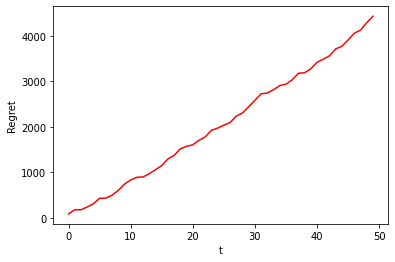

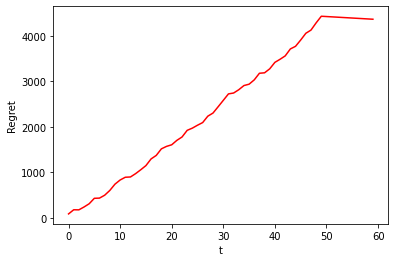

In [10]:
# list of the collected reward
rewards_per_experiment = []
opt = Optimizer.fit_table(all_optimal_subs)[1]
print(opt)

for i in range(0,n_obs):
    num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]
    rewards_per_experiment.append(num_clicks_day_i)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()




for i in range(0,10):

    rewards_per_experiment.append(Optimizer.fit_table(table_all_Subs)[1])

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()